In [4]:
#| default_exp ndwi_class

# NDWI 

In [5]:
#|hide
from nbdev.showdoc import *

In [6]:
#|export
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from flood_exercise import utils_func
from flood_exercise import const_vals as CONST

In [48]:
#|export

class ndwi():

  def __init__(self,
               path_to_s2_tiles : str , #path to the folder that contains the S2 images
               path_to_labeled_tiles : str , #path to the labled images (values -1,0,1)
               ):
    # get the list of tiles from each folder , get only files end with .tif
    self.tiles_s2 = utils_func.load_list_paths(path_to_s2_tiles, filter_file = True)
    self.labels = utils_func.load_list_paths(path_to_labeled_tiles , filter_file = True)

    self._get_ndwi_threshold_()


    # # get only tiles from specific region (Bolivia for the task) 
    # self.labels = [x for x in self.labels if CONST.REGION_STR_2 in x]


  # #calculate NDWI per pixel 
    
  #   for s2_path in self.tiles_s2:
  #       path_id = s2_path.split(CONST.SPLIT_TILES_NAMES_STR1)[-1].split(CONST.SPLIT_TILES_NAMES_STR2)[1]
  #       self.ndwi_img  = self._ndwi_s2_(s2_path)
        
  #       # find the matching label image 
  #       match_label_tile_path = [x for x in self.labels if path_id in x][0]
        
  #       self.match_label_tile = rasterio.open(match_label_tile_path)


  

  def _ndwi_s2_(self ,
                     path):
         
         with rasterio.open(path) as src:
            green = src.read(CONST.GREEN_BAND)
            nir = src.read(CONST.NIR_BAND)

            ndwi = (green - nir) / (green + nir)

            # Replace NaN values with 0
            ndwi = np.nan_to_num(ndwi, nan=-1)
            # # generate mask 
            # mask = np.where(ndwi<0 ,0 ,1)

            # #calculate precentage of water pixel out of all the pixels in the image
            # perc_water = round((np.sum(mask) / (mask.shape[0]*mask.shape[1]))*100,2)
         return ndwi #, mask ,perc_water
  


  def _get_ndwi_threshold_(self,
                           array : np.array , #numpy array to be checked for min and max values
                           ):
    
       threshold = [None , None]

       #for each image , calculate NDWI ,get the match labled image
       for s2_path in self.tiles_s2:
          
          #calculate NDWI, get the image id to match with the labels
          path_id = s2_path.split(CONST.SPLIT_TILES_NAMES_STR1)[-1].split(CONST.SPLIT_TILES_NAMES_STR2)[1]
          ndwi_img  = self._ndwi_s2_(s2_path)

          # match labeled image
          match_label_tile_path = [x for x in self.labels if path_id in x][0]
          match_label_tile = rasterio.open(match_label_tile_path).read(1)  

          #create water mask : change -1 to 0 
          water_mask = np.where(match_label_tile == -1, 0, match_label_tile)

          #multiply water_mask with NDWI :
          mask_ndwi = ndwi_img * water_mask
          
          #caluclate the min and max 
          min_val = mask_ndwi.min()
          max_val = mask_ndwi.max()

          if threshold[0] is None or min_val < threshold[0]:
              threshold[0] = min_val
          if threshold[1] is None or max_val > threshold[1]:
              threshold[1] = max_val


       return threshold

     


C:\Users\USER\AppData\Local\Temp\ipykernel_312\4112315081.py:41: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir)


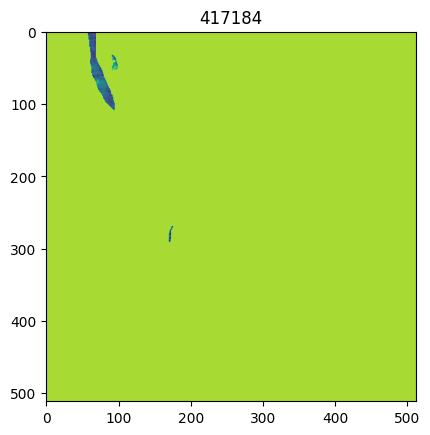

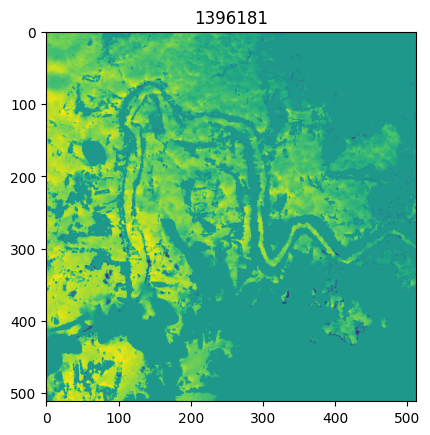

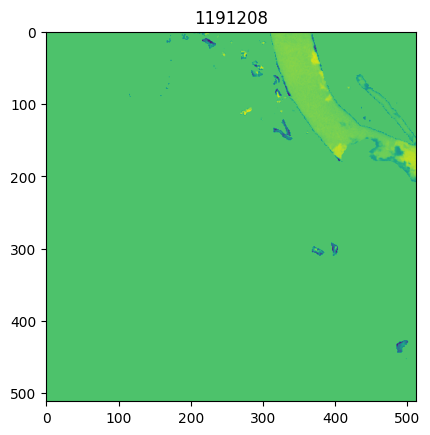

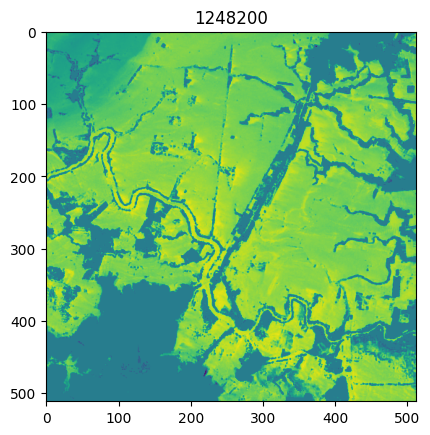

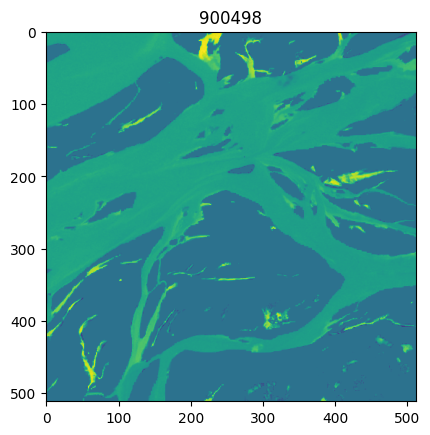

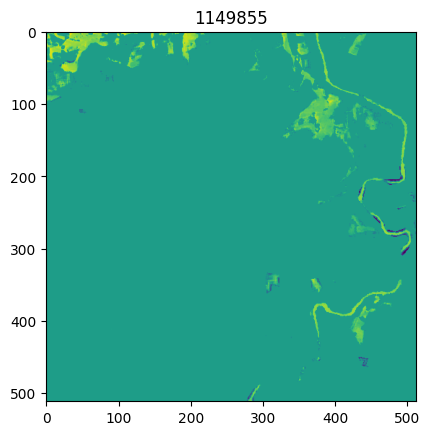

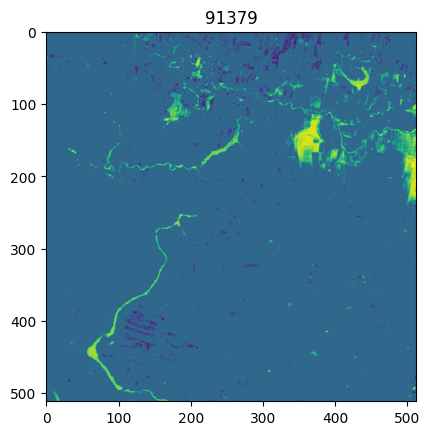

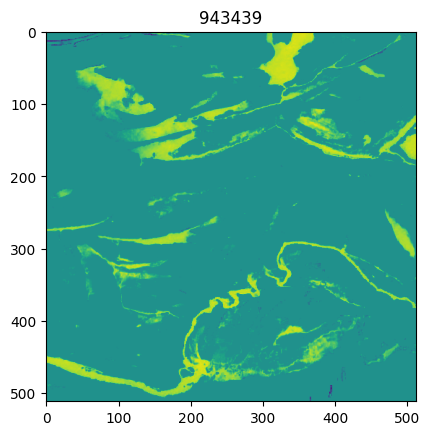

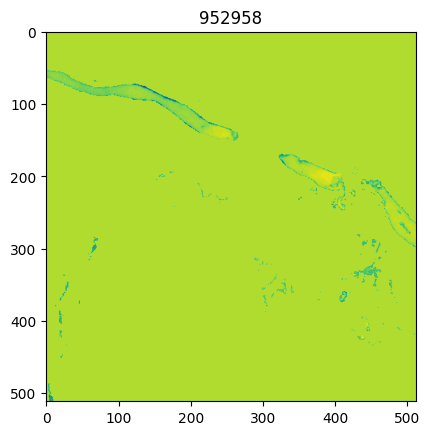

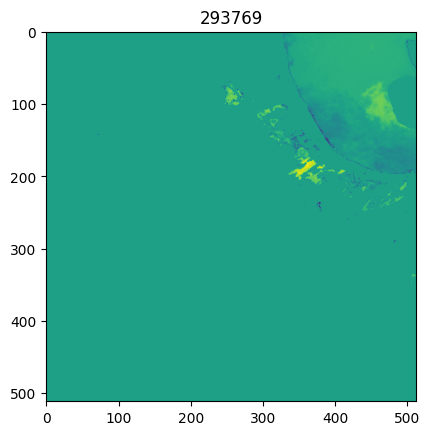

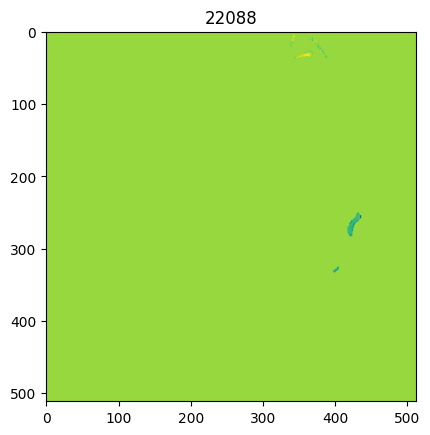

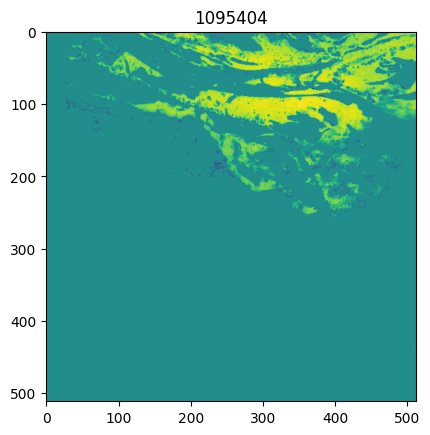

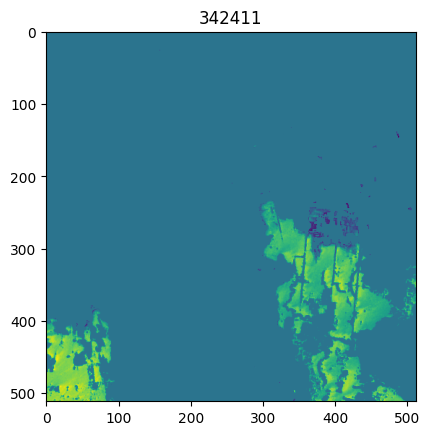

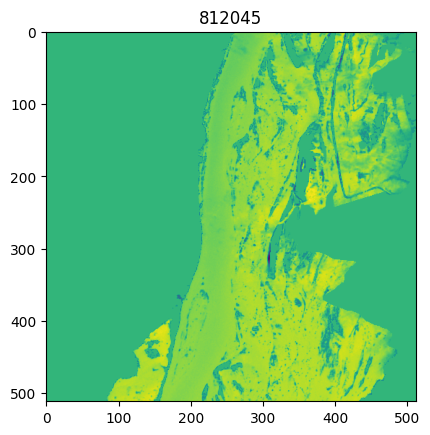

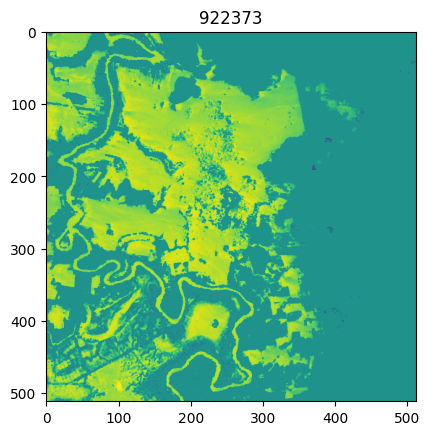

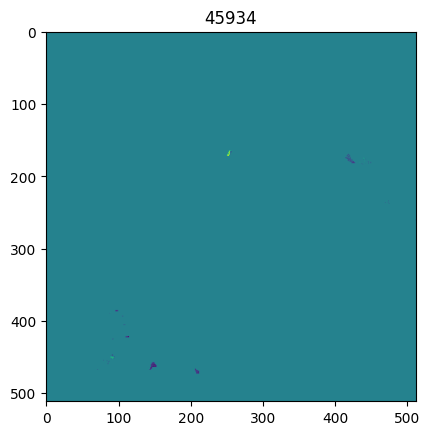

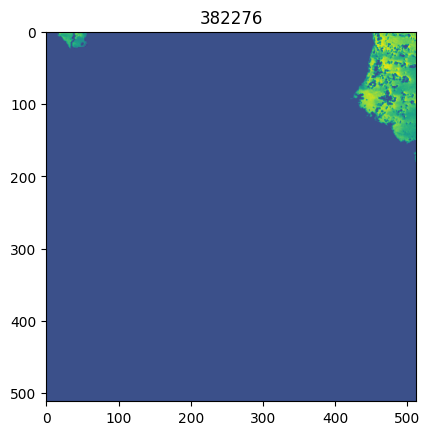

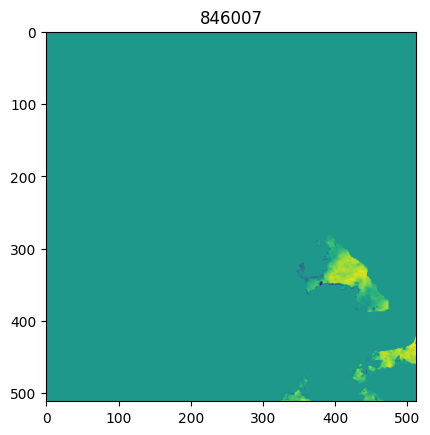

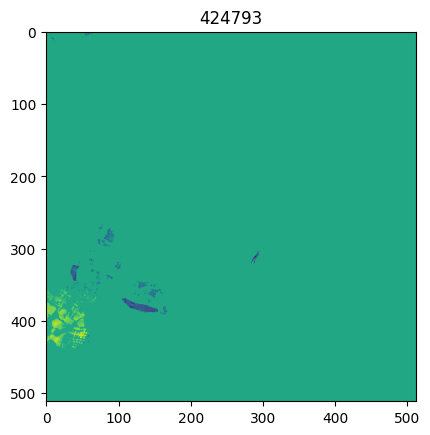

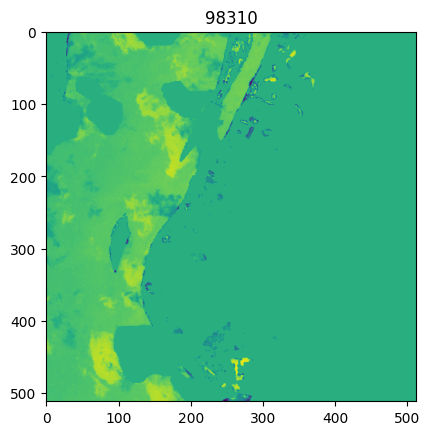

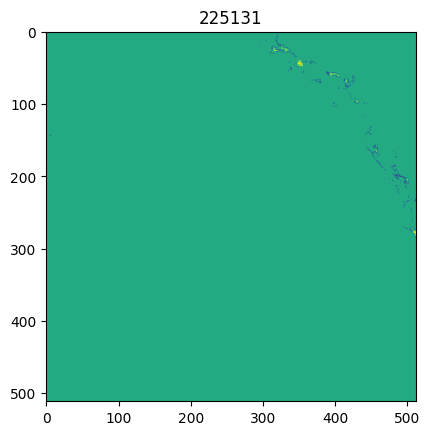

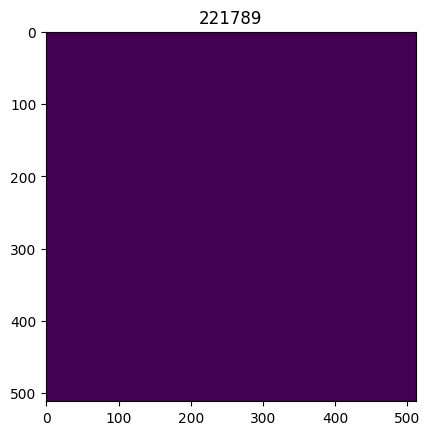

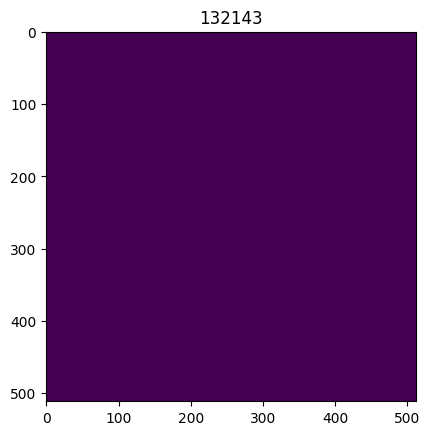

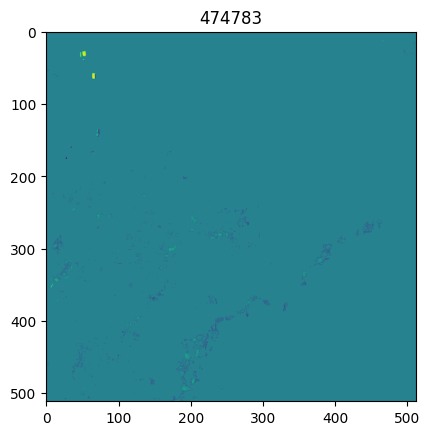

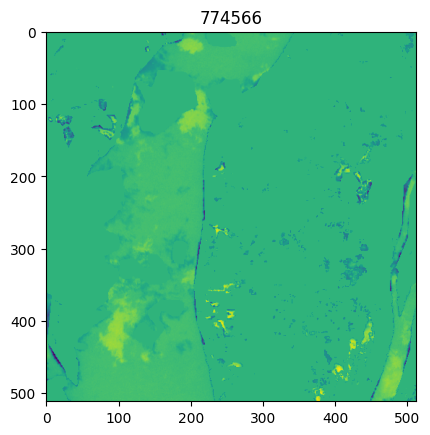

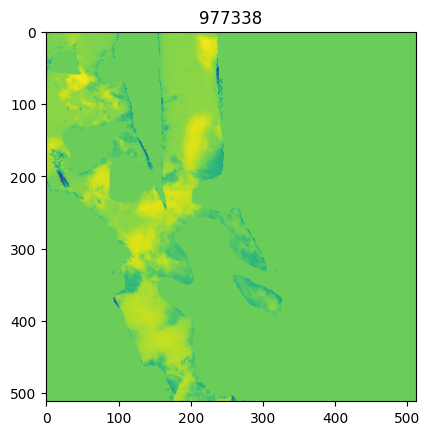

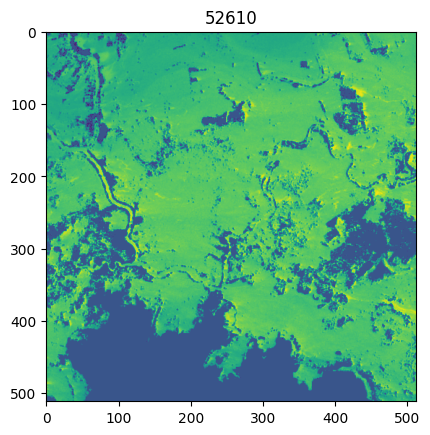

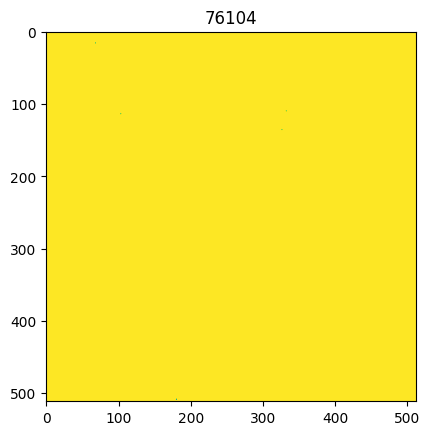

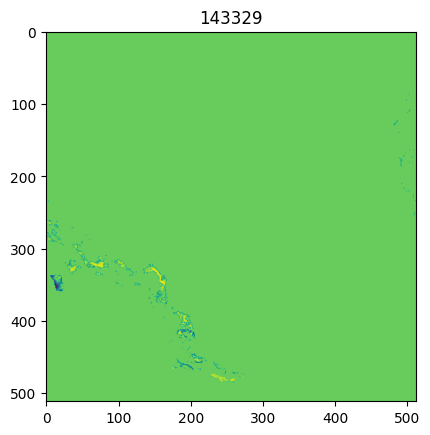

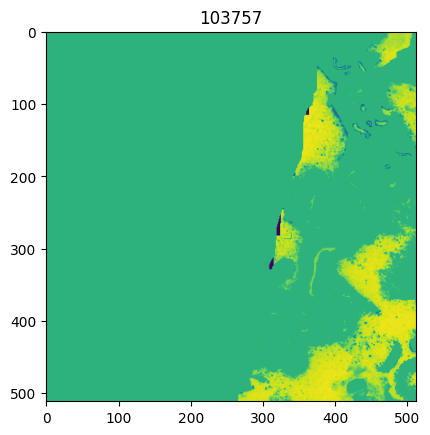

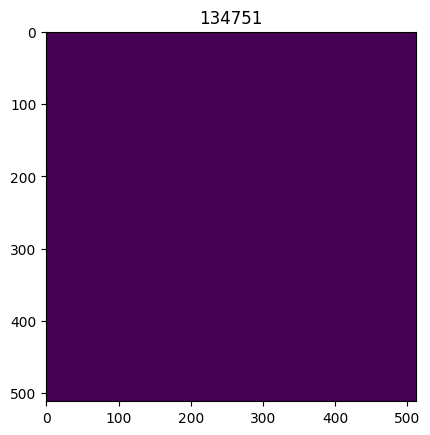

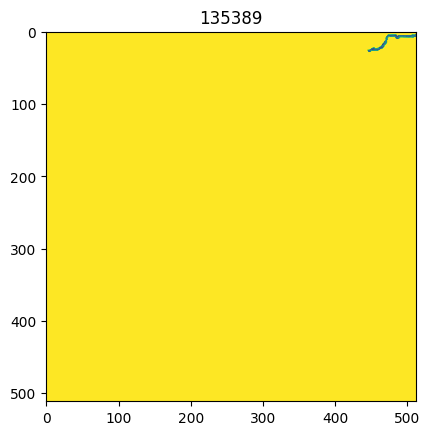

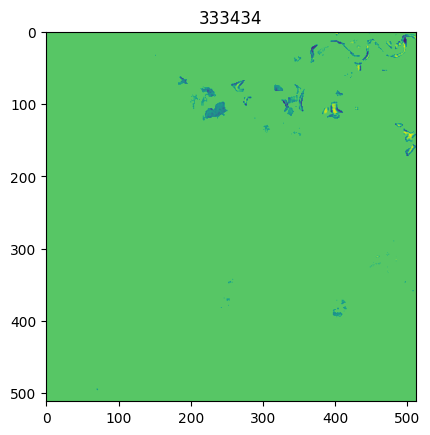

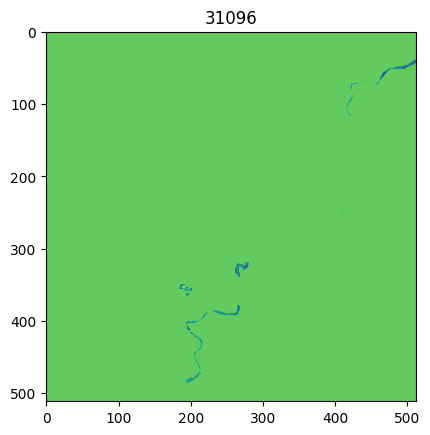

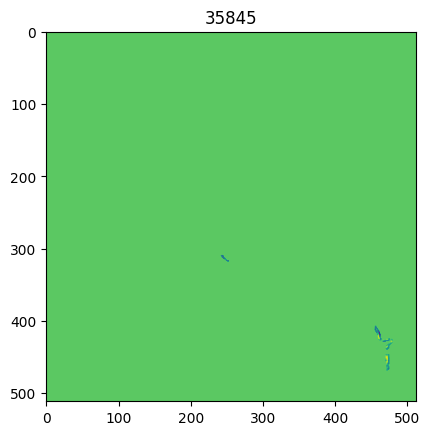

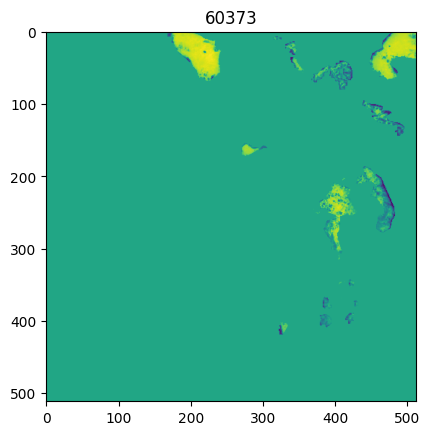

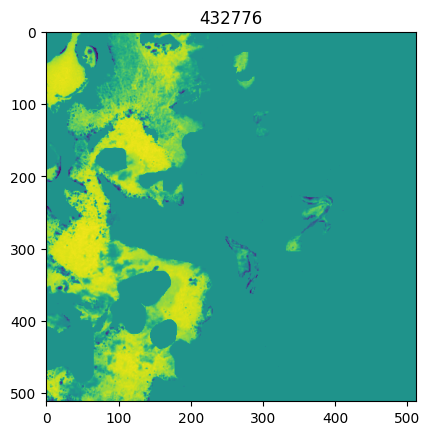

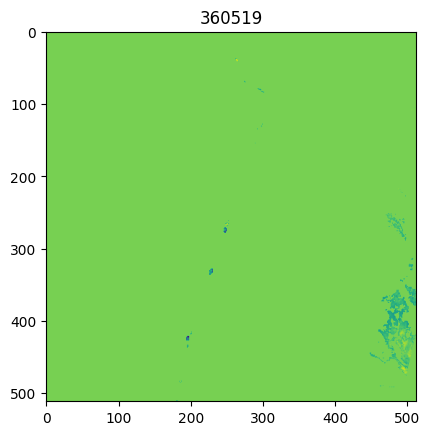

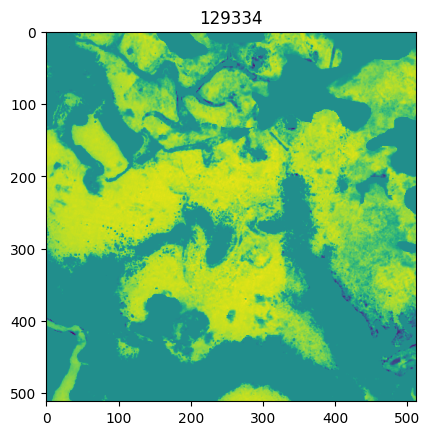

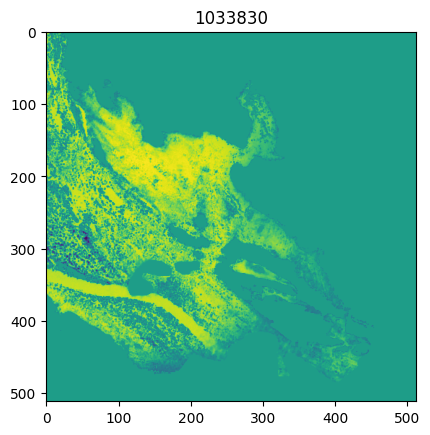

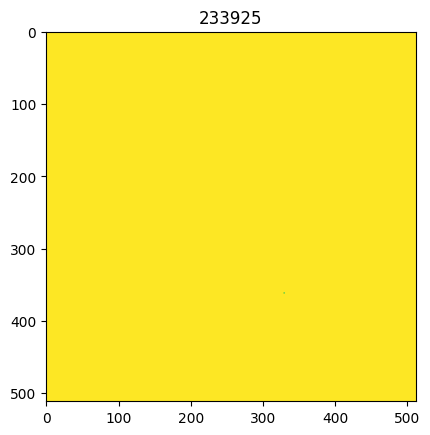

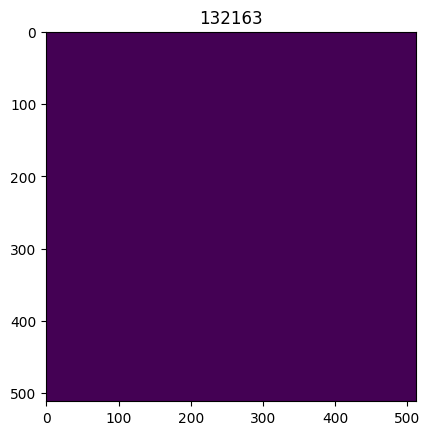

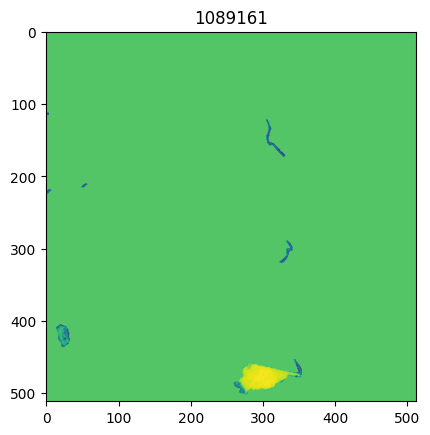

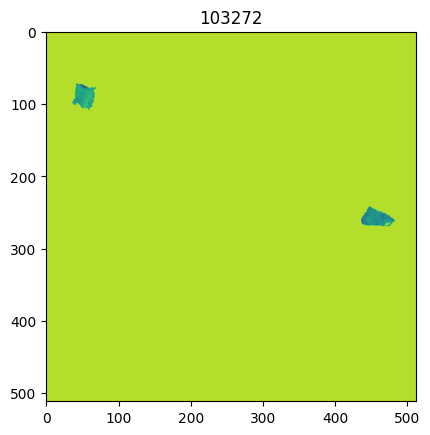

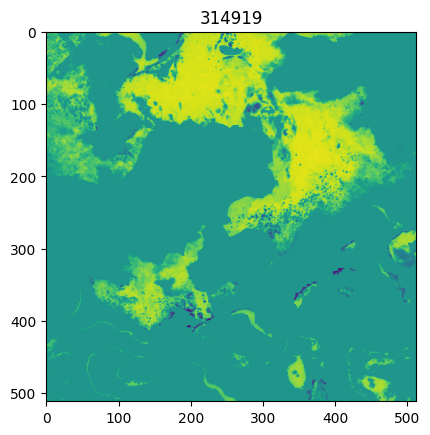

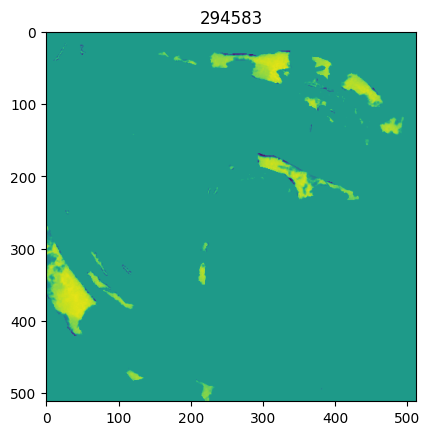

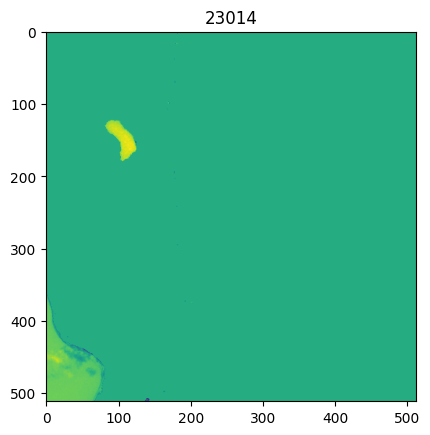

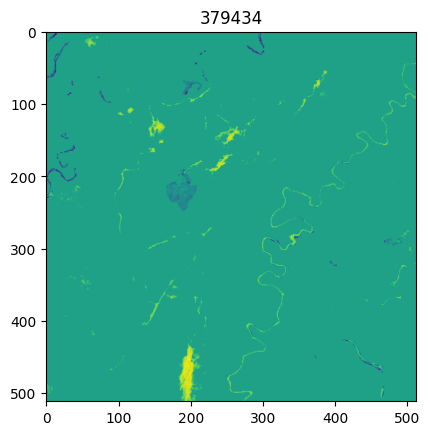

KeyboardInterrupt: 

In [49]:
instance = ndwi(path_to_s2_tiles = r"D:\git\flood_exercise\S2",
                path_to_labeled_tiles= r"D:\git\flood_exercise\S2_HANDLABELED")

# instance.water_perc.to_csv(r'D:\git\flood_exercise\RESULTS\water_perc_Bolivia.csv')

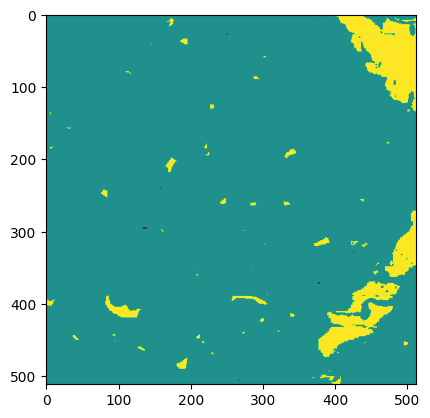

In [38]:
plt.imshow(instance.match_label_tile.read(1))

In [25]:
instance.labels[0].split("\\")[-1].split('_')[1]

'31096'

In [6]:
#|export

class ndwi():

  def __init__(self,
      path_to_imgs : str , # path to the folder that contains the images
      ):
     
     # get list of tif files
     self.list_of_files = utils_func.load_list_paths(path_to_imgs,filter_file = True)
     self.list_of_files = [x for x in self.list_of_files if 'Bolivia' in x]
     
     collector = {CONST.IMG_PATH_WATER_STR : [] , CONST.WATER_PERC_STR : []}
     # calculate NDWI and NDWI mask per image
     for path in self.list_of_files:
         self.ndwi_img ,self.mask , self.perc_water = self._ndwi_s2_(path)
         collector[CONST.IMG_PATH_WATER_STR].append(path)
         collector[CONST.WATER_PERC_STR].append(self.perc_water)

     self.water_perc = pd.DataFrame(collector)
           
  def _ndwi_s2_(self ,
                     path):
         
         with rasterio.open(path) as src:
            green = src.read(CONST.GREEN_BAND)
            nir = src.read(CONST.NIR_BAND)

            ndwi = (green - nir) / (green + nir)

            # Replace NaN values with 0
            ndwi = np.nan_to_num(ndwi, nan=-1)
            # generate mask 
            mask = np.where(ndwi<0 ,0 ,1)

            #calculate precentage of water pixel out of all the pixels in the image
            # count_water_pixels = np.sum(mask)
            # total_pixels = mask.shape[0]*mask.shape[1]
            perc_water = round((np.sum(mask) / (mask.shape[0]*mask.shape[1]))*100,2)
         return ndwi , mask ,perc_water
     




In [9]:
instance = ndwi(path_to_imgs = r"D:\git\flood_exercise\S2")
instance.water_perc.to_csv(r'D:\git\flood_exercise\RESULTS\water_perc_Bolivia.csv')

C:\Users\USER\AppData\Local\Temp\ipykernel_15656\3748574584.py:29: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir)
